<a href="https://colab.research.google.com/github/CBravoR/AdvancedAnalyticsLabs/blob/master/notebooks/python/Lab_LGD_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LGD Modelling

In this lab, we will model the LGD using two techniques: A linear regression, a fitted distribution regression, and a random forest. LGD models are particularly tricky as they tend to have oddly-shaped distributions, thus traditional methods do not tend to create good fit for the models.

First, we will install necessary packages, and then load and study the data.


In [1]:
!pip install distfit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.1/41.1 kB 2.6 MB/s eta 0:00:00


In [2]:
!gdown https://drive.google.com/uc?id=1nldxUFNGDziLZgE-fJv5KmNjnbdM29na

Downloading...
From: https://drive.google.com/uc?id=1nldxUFNGDziLZgE-fJv5KmNjnbdM29na
To: /content/LGD.csv
100% 36.9k/36.9k [00:00<00:00, 115MB/s]


In [96]:
# Basic imports
import numpy as np
import pandas as pd
import polars as pl
import polars.selectors as cs

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import GridSearchCV

# XGBoost import
from xgboost import XGBRegressor

# Curve fitter
import distfit

# Set seaborn style
sns.set_theme(style="darkgrid")

In [5]:
LGD_data = pl.read_csv('LGD.csv')
LGD_data.describe()

statistic,ratio1,ratio2,ratio3,ratio4,ratio5,ratio6,ratio7,ratio8,ratio9,ratio10,ratio11,ratio12,ratio13,LGD
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",506.0,506.0,506.0,506.0,506.0,506.0,506.0,506.0,506.0,506.0,506.0,506.0,506.0,506.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",12.461374,11.363636,11.136779,0.06917,0.554695,6.284634,68.574901,32.86332,9.549407,408.237154,18.455534,356.674032,12.653063,0.191396
"""std""",23.657443,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,21.732001,8.707259,168.537116,2.164946,91.294864,7.141062,0.186429
"""min""",0.00632,0.0,0.46,0.0,0.385,3.561,2.9,1.137,1.0,187.0,12.6,0.32,1.73,0.0021231
"""25%""",0.08199,0.0,5.19,0.0,0.449,5.885,45.0,17.572,4.0,279.0,17.4,375.33,6.93,0.076039
"""50%""",0.25915,0.0,9.69,0.0,0.538,6.209,77.7,27.175,5.0,330.0,19.1,391.45,11.38,0.13402
"""75%""",13.913,12.5,18.1,0.0,0.624,6.625,94.1,46.947,24.0,666.0,20.2,396.23,16.96,0.20592
"""max""",99.665,100.0,27.74,1.0,0.871,8.78,100.0,92.229,24.0,711.0,22.0,396.9,37.97,0.98


Let's create a test / train split.

In [6]:
x_train, x_test, y_train, y_LGD_test = train_test_split( LGD_data.select(pl.exclude('LGD')), # Predictors
                                                    LGD_data['LGD'],         # Target variable
                                                    test_size=0.33,          # Test size percentage
                                                    random_state=20201209    # Seed
                                                    )

And finally let's plot the LGD distribution.

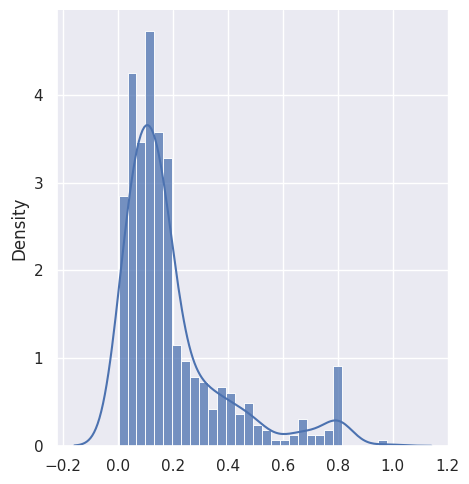

In [7]:
# Create the figure with the density
fig = sns.displot(LGD_data['LGD'], kind = 'kde')

# Create a density histogram
sns.histplot(LGD_data['LGD'], stat = 'density')

# Plot the whole thing
plt.show()

As we can see, the LGD has an unbalanced bimodal distribution between 0 and 1.

## Linear regression

We will now try to fit a basic linear regression and see its performance. For this we will use the linear regression implementation of scikit-learn, [```linear_model```](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model). We will also regularize using ElasticNet.

In [8]:
LGD_linear_model = ElasticNetCV(l1_ratio=np.arange(0.01, 1.01, 0.05),  # l1_ratios to try.
                                n_alphas=10,                        # How many alphas to try per l1_ratio
                                fit_intercept=True,                 # Use constant?
                                max_iter=1000,                      # Iterations
                                tol=0.0001,                         # Parameter tolerance
                                cv=3,                               # Number of cross_validation folds
                                verbose=True,                       # Explicit or silent training
                                n_jobs=2,                           # Cores to use
                                random_state=20201209               # Random seed
                                )

In [9]:
LGD_linear_model.fit(x_train, y_train)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
..................................................................................................................................[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:    0.2s finished


ElasticNetCV(cv=3,
             l1_ratio=array([0.01, 0.06, 0.11, 0.16, 0.21, 0.26, 0.31, 0.36, 0.41, 0.46, 0.51,
       0.56, 0.61, 0.66, 0.71, 0.76, 0.81, 0.86, 0.91, 0.96]),
             n_alphas=10, n_jobs=2, random_state=20201209, verbose=True)

Let's check the output.

In [10]:
coef_df = pd.concat([pd.DataFrame({'column': x_train.columns}),
                    pd.DataFrame(np.transpose(LGD_linear_model.coef_))],
                    axis = 1
                   )

coef_df

,column,0
0,ratio1,-0.000334
1,ratio2,0.000680
2,ratio3,0.000000
3,ratio4,0.000000
4,ratio5,-0.000000
5,ratio6,0.083031
6,ratio7,0.000430
7,ratio8,-0.000989
8,ratio9,0.005202
9,ratio10,-0.000185


In [11]:
LGD_linear_model.l1_ratio_

np.float64(0.9600000000000001)

The model is highly leaning towards LASSO. We can see some variables are not relevant. Let's check the goodness of fit over the test set.

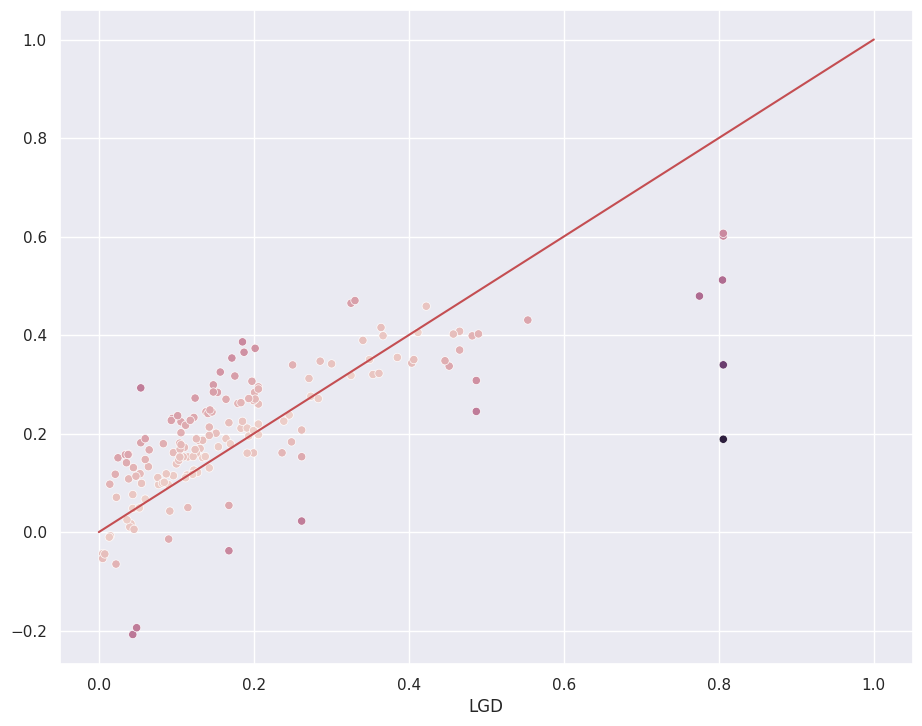

In [12]:
# Predict over test set
linear_pred_test = LGD_linear_model.predict(x_test)

# Calculate the error
linear_error = np.abs(linear_pred_test - y_LGD_test)

# Print a scatter plot with distributions.
fig, ax = plt.subplots(figsize=(11, 8.5))
sns.scatterplot(x = y_LGD_test,            # The x is the real value
                y = linear_pred_test,  # The y value is the predictor
                hue = linear_error,    # The colour represents the error
                legend = False
                )

# Overlay a diagonal line
X_plot = np.linspace(0, 1, 100)
Y_plot = X_plot

plt.plot(X_plot, Y_plot, color='r')

plt.show()

We can see several values are predicted to be below 0, while many are shown to be below its correct value, particularly for large graphs. How dark a point shows the error magnitud. Let's see the average error magnitud.

In [13]:
linear_mse = mean_squared_error(y_LGD_test, linear_pred_test)
print(f'The MSE for the linear model is {linear_mse:.4f}')

The MSE for the linear model is 0.0132


## General Linear Regression Fit

General regressions are not implemented in Python yet. This means we should use the GLM trick that we saw in the lectures to estimate a regression model that has an appropriate output distribution. Let's see how this would work out.

The first step is to look for the best distribution for our data. For this we can use the [```distfit```](https://erdogant.github.io/distfit/pages/html/index.html) package, that tries to find the best distribution among all available in scipy.

Now we can look for the best distribution. The process is:
1.  Create the fitter object.
2. Fit it over our LGD data.
3. Pick the best distribution between all available.

Not all distributions are good for our problem. This can greatly increase fitting time too. Let's restrict distributions to those we believe might be adequate for our case. The full list of distributions available can be found [here](https://erdogant.github.io/distfit/pages/html/Parametric.html).

In [57]:
# Pick a few distributions.
distributions = ['beta', 'gamma', 'mielke', 'lognorm', 'burr', 'invgamma', 'pearson3', 'weibull_min']

# Regenerate the object with selected distributions
dists_LGD = distfit.distfit(distr = distributions,
                            n_jobs=2, # Parallel processing (bootstrap)
                            n_boots=100,      # Number of bootstraps.
                            todf=True        # Return results as dataframe
                            )

In [58]:
# Fit it
dists_LGD.fit_transform(LGD_data['LGD'].to_numpy())

[04-12-2025 18:37:34] [distfit.distfit] [INFO] fit
[04-12-2025 18:37:34] [distfit.distfit] [INFO] transform
[04-12-2025 18:37:38] [distfit.distfit] [INFO] [beta       ] [4.39 sec] [RSS: 19.8192] [loc=0.002 scale=0.990]
[04-12-2025 18:37:39] [distfit.distfit] [INFO] [gamma      ] [1.03 sec] [RSS: 7.66605] [loc=0.002 scale=0.152]
[04-12-2025 18:37:42] [distfit.distfit] [INFO] [mielke     ] [2.99 sec] [RSS: 4.45174] [loc=0.002 scale=0.187]
[04-12-2025 18:37:44] [distfit.distfit] [INFO] [lognorm    ] [1.46 sec] [RSS: 5.41148] [loc=-0.012 scale=0.143]
[04-12-2025 18:37:50] [distfit.distfit] [INFO] [burr       ] [6.61 sec] [RSS: 4.45187] [loc=0.002 scale=0.187]
[04-12-2025 18:37:52] [distfit.distfit] [INFO] [invgamma   ] [1.35 sec] [RSS: 5.08797] [loc=-0.051 scale=0.449]
[04-12-2025 18:37:56] [distfit.distfit] [INFO] [pearson3   ] [3.81 sec] [RSS: 7.66559] [loc=0.191 scale=0.170]
[04-12-2025 18:37:57] [distfit.distfit] [INFO] [weibull_min] [1.07 sec] [RSS: 9.01515] [loc=0.002 scale=0.197]
[0

{'model': {'name': 'burr',
  'score': 4.451872366996787,
  'loc': 0.0017205369611745062,
  'scale': 0.1870037671433789,
  'arg': (np.float64(2.2051034316075038), np.float64(0.6014100622777372)),
  'params': (np.float64(2.2051034316075038),
   np.float64(0.6014100622777372),
   np.float64(0.0017205369611745062),
   np.float64(0.1870037671433789)),
  'model': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7d6f8815adb0>,
  'bootstrap_score': 0.48,
  'bootstrap_pass': True,
  'color': '#e41a1c',
  'CII_min_alpha': np.float64(0.021316433807167),
  'CII_max_alpha': np.float64(0.5617699528794102)},
 'summary':           name     score       loc     scale  \
 0         burr  4.451872  0.001721  0.187004   
 1       mielke  4.451744  0.001721  0.186995   
 2     invgamma  5.087969 -0.050772  0.449068   
 3      lognorm  5.411476 -0.012041  0.143427   
 4     pearson3   7.66559  0.191396  0.169876   
 5        gamma  7.666053  0.001951  0.152332   
 6  weibull_min  9.015148  0.0020

In [59]:
# Best model
dists_LGD.model

{'name': 'burr',
 'score': 4.451872366996787,
 'loc': 0.0017205369611745062,
 'scale': 0.1870037671433789,
 'arg': (np.float64(2.2051034316075038), np.float64(0.6014100622777372)),
 'params': (np.float64(2.2051034316075038),
  np.float64(0.6014100622777372),
  np.float64(0.0017205369611745062),
  np.float64(0.1870037671433789)),
 'model': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7d6f8815adb0>,
 'bootstrap_score': 0.48,
 'bootstrap_pass': True,
 'color': '#e41a1c',
 'CII_min_alpha': np.float64(0.021316433807167),
 'CII_max_alpha': np.float64(0.5617699528794102)}

[04-12-2025 18:38:10] [distfit.distfit] [INFO] Create pdf plot for the parametric method.
[04-12-2025 18:38:10] [distfit.distfit] [INFO] Estimated distribution: Burr(loc:0.001721, scale:0.187004)


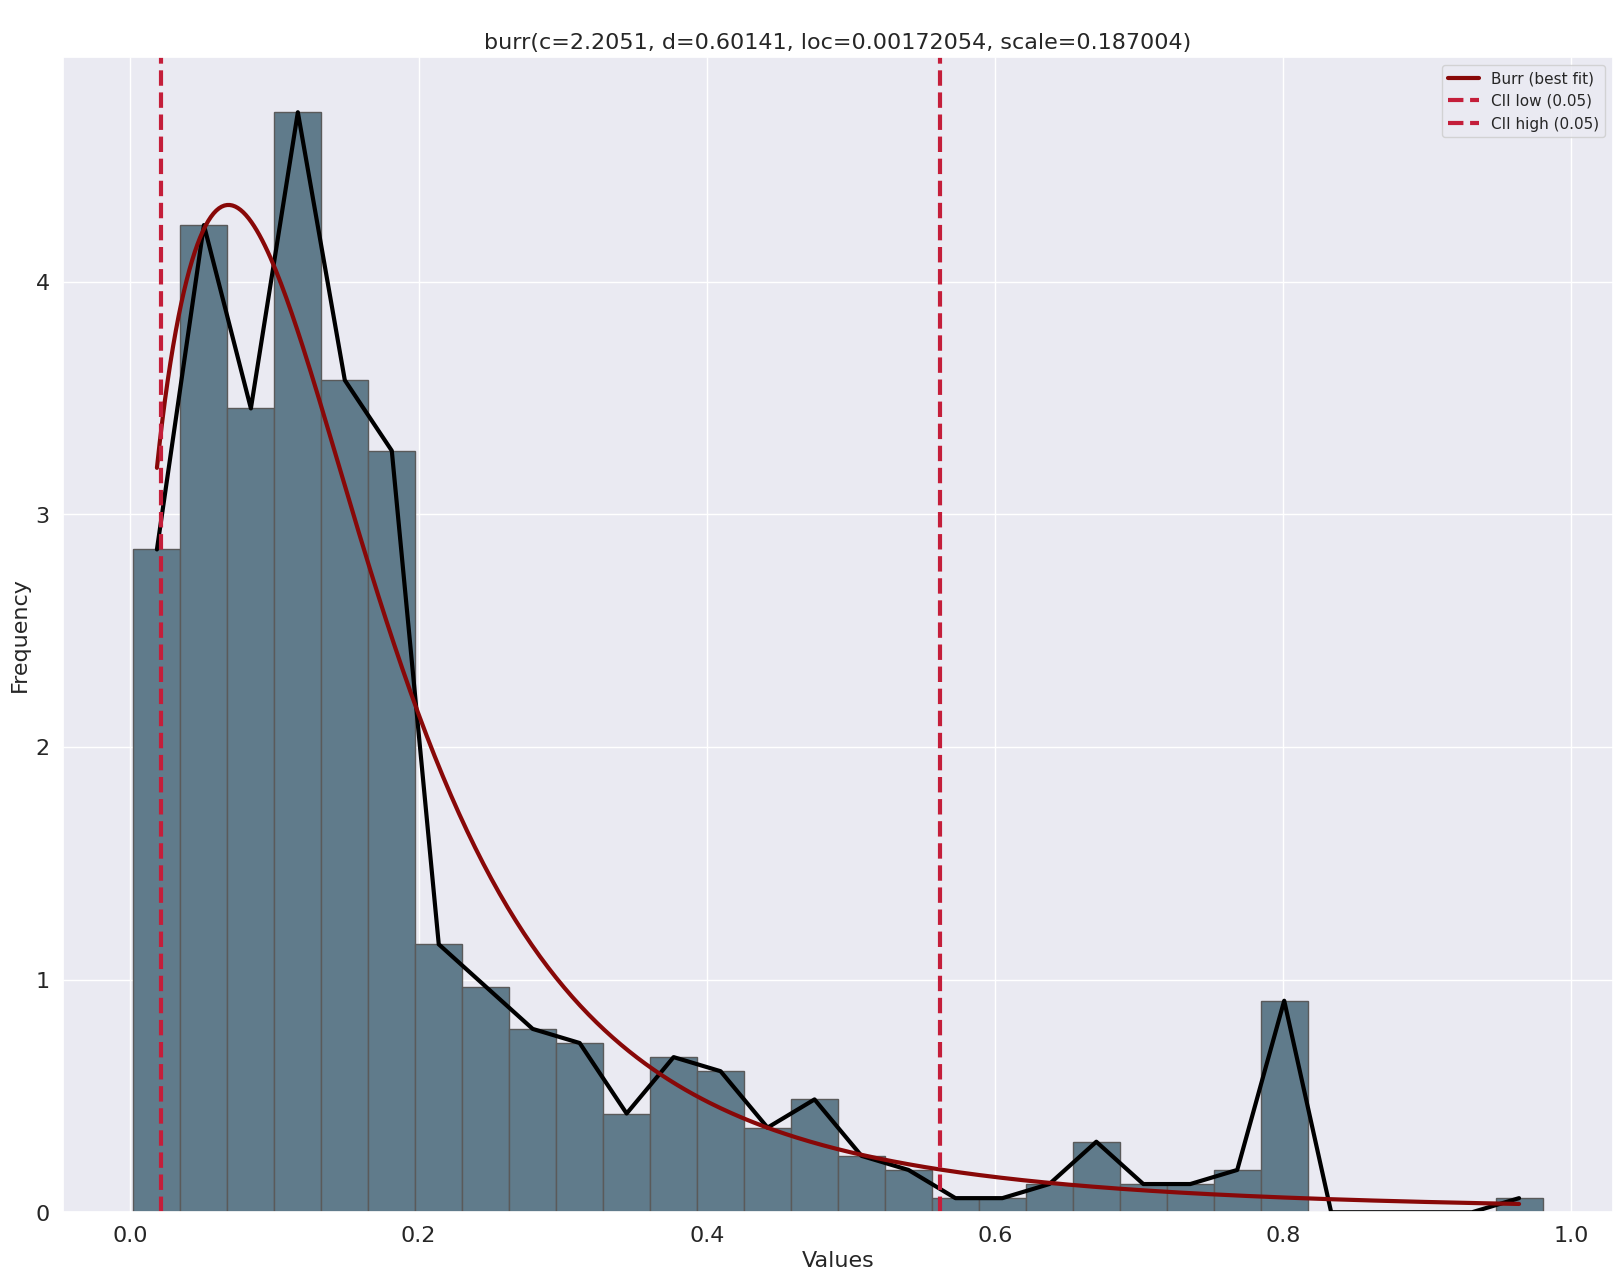

In [60]:
# Plot the best distribution
dists_LGD.plot()
plt.show()

[04-12-2025 18:38:21] [distfit.distfit] [INFO] Ploting Summary.


/usr/local/lib/python3.12/dist-packages/distfit/distfit.py:1324: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticks, fontsize=fontsize)
[04-12-2025 18:38:21] [distfit.distfit] [INFO] Bootstrap results are included..


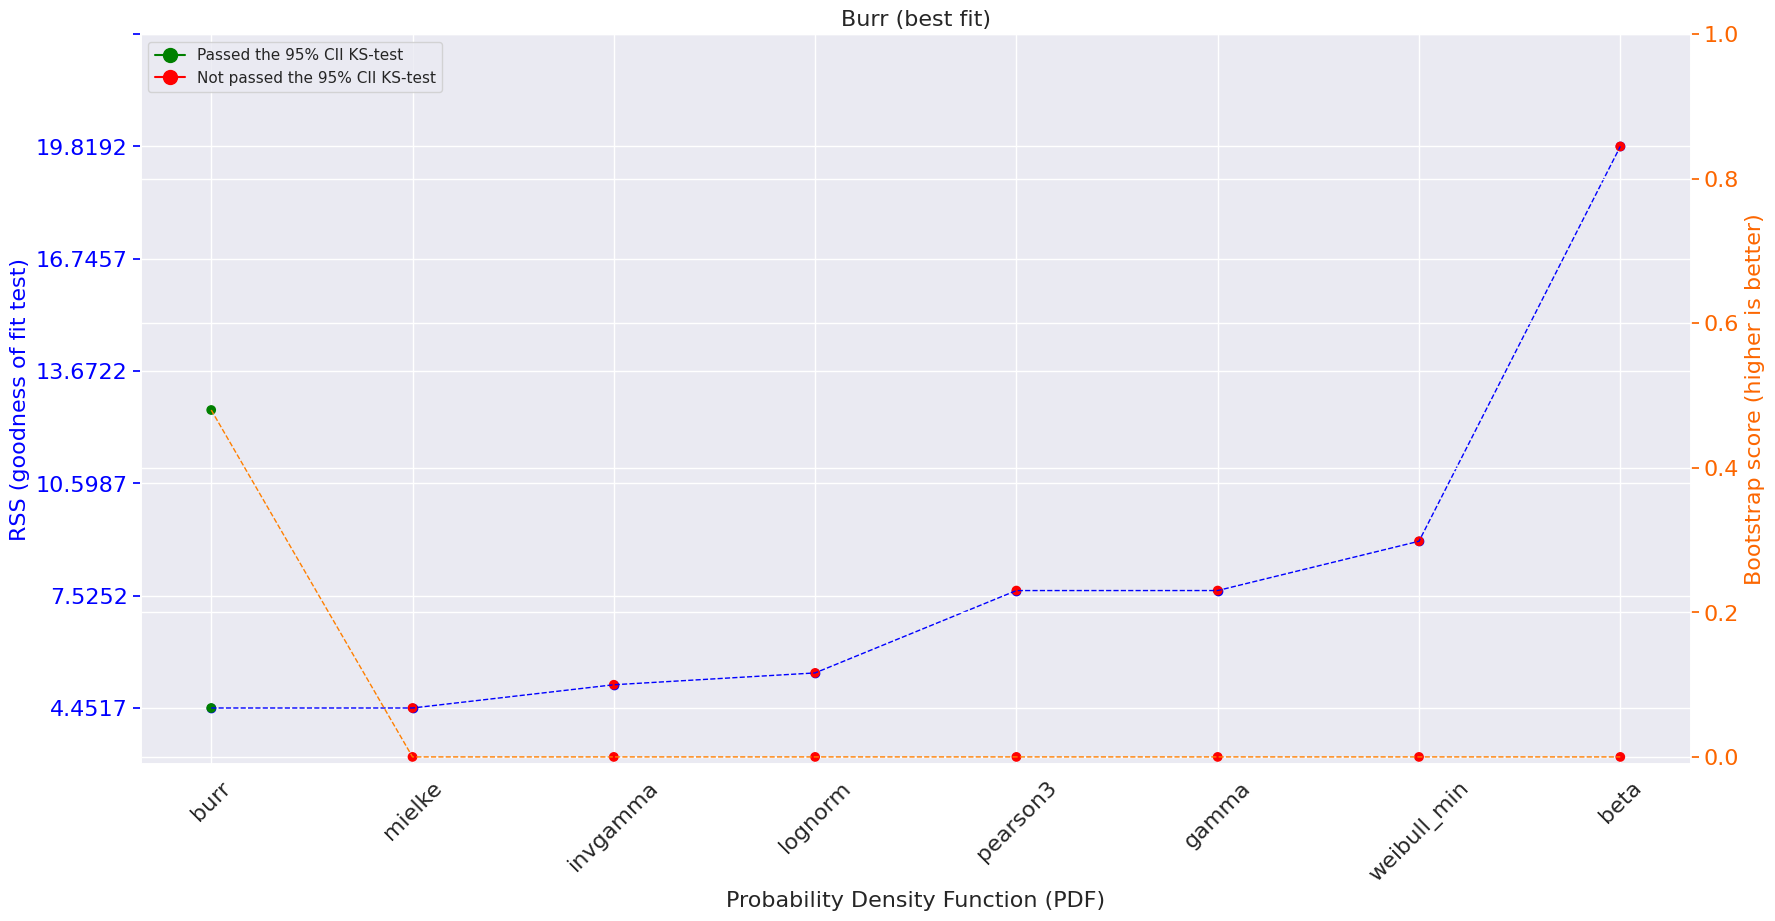

In [61]:
# Plot summary of all distributions tried
dists_LGD.plot_summary()
plt.show()

We can see the best distribution, and the only one that passes the bootstrap test, is the [Burr distribution](https://en.wikipedia.org/wiki/Burr_distribution), also known as the log-logistic distribution. Every dataset can have its own distribution!

The function for the [Burr's density distribution](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.burr.html) is precalculated and stored in the ```model``` property. 

What functions do we need? Well, the general process for a regression of this type is:

1. Get where on the original cumulative distribution a point (the LGD) falls. For this we need the cumulative Burr distribution, called the ```cdf``` function in scipy.
2. Get where on the normal distribution that particular point falls. For this we need the inverse of the cumulative function, also called the **percent point function** or ```ppf``` in scipy.
3. Apply this to all points in the dataset. Now everything is mapped to a normal variable.
4. Run a linear regression between our regressors and the z-transformed variable. You can use LASSO, ElasticNet, etc to get the best model.
5. Go back. For this you need the cumulative normal distribution function (cdf) and the inverse cumulative distribution function for our target distribution (Burr's ppf function).
Let's import all required functions.

In [62]:
# Import the functions
from scipy.stats import burr, norm

In [75]:
# Read from the fitted parameters and create the distribution object
LGD_burr = dists_LGD.model['model'] # Asterisk means split the array into parameters for the function
LGD_normal = norm()

In [ ]:
# Set the parameters to particular values.
LGD_burr = dists_LGD.model # Create a copy of the fitted distribution
LGD_normal = norm()

Let's begin the calculations. The first step is to get the CDF of all elements in the Mielke distribution and finding its corresponding z-value in the normal distribution.

In [79]:
LGD_data

ratio1,ratio2,ratio3,ratio4,ratio5,ratio6,ratio7,ratio8,ratio9,ratio10,ratio11,ratio12,ratio13,LGD
f64,f64,f64,i64,f64,f64,f64,f64,i64,i64,f64,f64,f64,f64
0.09252,30.0,4.93,0,0.428,6.606,42.2,61.899,6,300,16.6,383.78,7.37,0.20811
0.98843,0.0,8.14,0,0.538,5.813,100.0,40.952,4,307,21.0,394.54,19.88,0.05572
0.21409,22.0,5.86,0,0.431,6.438,8.9,73.967,7,330,19.1,377.07,3.59,0.24563
0.11425,0.0,13.89,1,0.55,6.373,92.4,33.633,5,276,16.4,393.74,10.5,0.20099
0.03932,0.0,3.41,0,0.489,6.405,73.9,30.921,2,270,17.8,393.55,8.2,0.17822
…,…,…,…,…,…,…,…,…,…,…,…,…,…
0.0686,0.0,2.89,0,0.445,7.416,62.5,34.952,2,276,18.0,396.9,6.19,0.40646
0.38735,0.0,25.65,0,0.581,5.613,95.6,17.572,2,188,19.1,359.29,27.26,0.060882
0.0315,95.0,1.47,0,0.403,6.975,15.3,76.534,3,402,17.0,396.9,4.56,0.45208


In [83]:
# Create the 'BurrCDF' column by getting the Burr cdf point.
LGD_data = LGD_data.with_columns(
    pl.col('LGD').map_elements(lambda x: LGD_burr.cdf(x), return_dtype=pl.Float64)
    .alias('BurrCDF')
)

# Get the corresponding z-value in the normal function
LGD_data = LGD_data.with_columns(
    pl.col('BurrCDF').map_elements(lambda x: norm.ppf(x), return_dtype=pl.Float64)
    .alias('Z-Burr')
)

# Get new summary statistics for all columns
LGD_data.describe()

statistic,ratio1,ratio2,ratio3,ratio4,ratio5,ratio6,ratio7,ratio8,ratio9,ratio10,ratio11,ratio12,ratio13,LGD,BurrCDF,Z-Burr
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",506.0,506.0,506.0,506.0,506.0,506.0,506.0,506.0,506.0,506.0,506.0,506.0,506.0,506.0,506.0,506.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",12.461374,11.363636,11.136779,0.06917,0.554695,6.284634,68.574901,32.86332,9.549407,408.237154,18.455534,356.674032,12.653063,0.191396,0.50062,0.00203
"""std""",23.657443,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,21.732001,8.707259,168.537116,2.164946,91.294864,7.141062,0.186429,0.287462,1.000258
"""min""",0.00632,0.0,0.46,0.0,0.385,3.561,2.9,1.137,1.0,187.0,12.6,0.32,1.73,0.0021231,0.00029,-3.440374
"""25%""",0.08199,0.0,5.19,0.0,0.449,5.885,45.0,17.572,4.0,279.0,17.4,375.33,6.93,0.076039,0.273179,-0.603227
"""50%""",0.25915,0.0,9.69,0.0,0.538,6.209,77.7,27.175,5.0,330.0,19.1,391.45,11.38,0.13402,0.502034,0.005098
"""75%""",13.913,12.5,18.1,0.0,0.624,6.625,94.1,46.947,24.0,666.0,20.2,396.23,16.96,0.20592,0.696729,0.515015
"""max""",99.665,100.0,27.74,1.0,0.871,8.78,100.0,92.229,24.0,711.0,22.0,396.9,37.97,0.98,0.984667,2.161392


Our data is perfectly mapped to a normal regression. Now we are ready to run the regression! We can use the same code as before, but our target now will be the newly calculate Z-Burr variable.

In [88]:
LGD_burr_model = ElasticNetCV(l1_ratio=np.arange(0.01, 1.01, 0.05),  # l1_ratios to try.
                                n_alphas=10,                        # How many alphas to try per l1_ratio
                                fit_intercept=True,                 # Use constant?
                                max_iter=1000,                      # Iterations
                                tol=0.0001,                         # Parameter tolerance
                                cv=3,                               # Number of cross_validation folds
                                verbose=True,                       # Explicit or silent training
                                n_jobs=2,                           # Cores to use
                                random_state=20201209               # Random seed
                                )

In [89]:
x_train, x_test, y_train, y_burr_test = train_test_split( LGD_data.select(pl.exclude('LGD')), # Predictors
                                                    LGD_data['Z-Burr'],         # Target variable
                                                    test_size=0.33,          # Test size percentage
                                                    random_state=20201209    # Seed
                                                    )

In [90]:
LGD_burr_model.fit(x_train, y_train)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
............................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
............................................................................................................................................[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:    0.2s finished


ElasticNetCV(cv=3,
             l1_ratio=array([0.01, 0.06, 0.11, 0.16, 0.21, 0.26, 0.31, 0.36, 0.41, 0.46, 0.51,
       0.56, 0.61, 0.66, 0.71, 0.76, 0.81, 0.86, 0.91, 0.96]),
             n_alphas=10, n_jobs=2, random_state=20201209, verbose=True)

In [91]:
coef_df = pd.concat([pd.DataFrame({'column': x_train.columns}),
                    pd.DataFrame(np.transpose(LGD_burr_model.coef_))],
                    axis = 1
                   )

coef_df

,column,0
0,ratio1,0.000000
1,ratio2,0.000895
2,ratio3,-0.000000
3,ratio4,0.000000
4,ratio5,-0.000000
5,ratio6,0.000000
6,ratio7,0.000188
7,ratio8,-0.000379
8,ratio9,0.000983
9,ratio10,-0.000349


Similar variables are relevant now, but the weights have clearly changed! We can now apply this model to the test data and then calculate the corresponding LGD by reversing our procedure.

In [92]:
# Predict over test set
burr_pred_test = LGD_burr_model.predict(x_test)
burr_pred_test = norm.cdf(burr_pred_test)
burr_pred_test = LGD_burr.ppf(burr_pred_test)

# Calculate the error
burr_error = np.abs(burr_pred_test - y_LGD_test)


Now that we have the estimates and the error, we can plot our results and calculate the MSE.

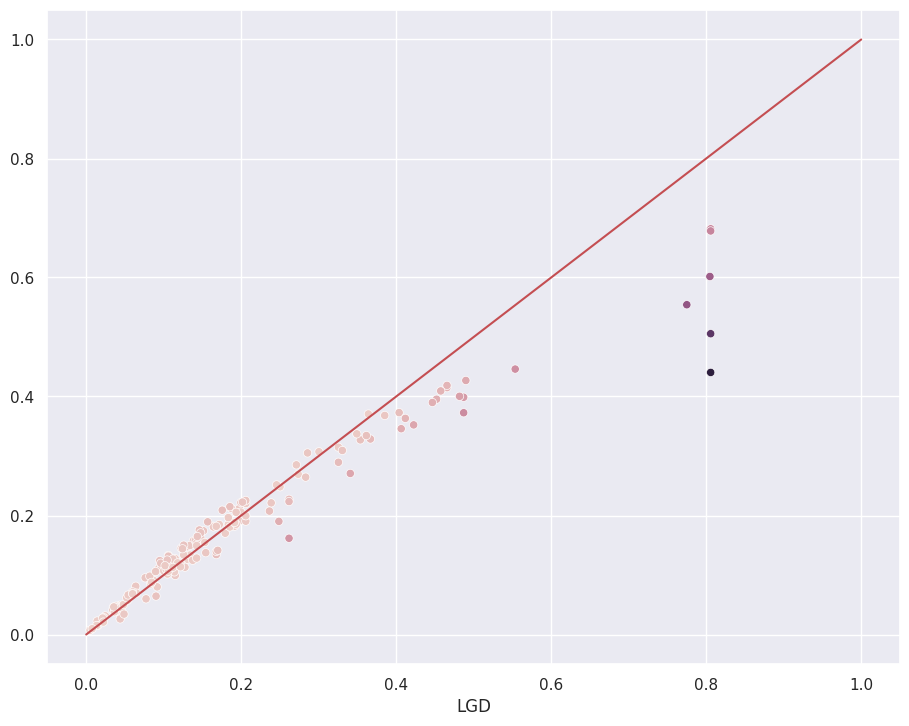

In [93]:

# Print a scatter plot with distributions.
fig, ax = plt.subplots(figsize=(11, 8.5))
sns.scatterplot(x = y_LGD_test,            # The x is the real value
                y = burr_pred_test,  # The y value is the predictor
                hue = burr_error,    # The colour represents the error
                legend = False
                )

# Overlay a diagonal line
X_plot = np.linspace(0, 1, 100)
Y_plot = X_plot

plt.plot(X_plot, Y_plot, color='r')

plt.show()

In [ ]:
# Print the MSE
linear_mse = mean_squared_error(y_LGD_test, burr_pred_test)
print('The MSE for the Burr-distributed model is %.4f' % linear_mse)

The MSE for the Burr-distributed model is 0.0028


So we got a lower error! The improvement is significant, but besides getting a better error we also get a better distribution: Our model starts at 0 and covers most of the original range. We can use this trick to create a regression for any distribution we want. Let's train now an XGBoosting method to compare.

## XGBoosting

The only difference between the models we ran in the XGB lab is the fact that this is a regression problem instead of a classification one. There is no issue with bounds (as opposed to a linear regression) as an XGB always produces estimates within the bounds of the model.

First, we recover the original dataset.

In [95]:
x_train, x_test, y_train, y_LGD_test = train_test_split( LGD_data.drop('LGD'), # Predictors
                                                    LGD_data['LGD'],         # Target variable
                                                    test_size=0.33,          # Test size percentage
                                                    random_state=20201209    # Seed
                                                    )

In [102]:
#Define the classifier.
XGB_LGD = XGBRegressor(max_depth=2,                 # Depth of each tree
                      learning_rate=0.1,            # How much to shrink error in each subsequent training. Trade-off with no. estimators.
                      n_estimators=200,             # How many trees to use, the more the better, but decrease learning rate if many used.
                      verbosity=1,                  # If to show more errors or not.
                      objective='reg:squarederror',  # Type of target variable.
                      booster='gbtree',             # What to boost. Trees in this case.
                      n_jobs=2,                    # Parallel jobs to run. Set your processor number.
                      gamma=0.001,                  # Minimum loss reduction required to make a further partition on a leaf node of the tree. (Controls growth!)
                      subsample=0.632,              # Subsample ratio. Can set lower
                      colsample_bytree=1,           # Subsample ratio of columns when constructing each tree.
                      colsample_bylevel=1,          # Subsample ratio of columns when constructing each level. 0.33 is similar to random forest.
                      colsample_bynode=1,           # Subsample ratio of columns when constructing each split.
                      reg_alpha=1,                  # Regularizer for first fit. alpha = 1, lambda = 0 is LASSO.
                      reg_lambda=0,                 # Regularizer for first fit.
                      random_state=20230331,        # Seed
                      tree_method='hist',           # How to train the trees?
                      #gpu_id=0                     # With which GPU?
                      eval_metric=mean_squared_error, # Metric used for monitoring the training result and early stopping.
                      early_stopping_rounds=5 #  Validation metric needs to improve at least once in every early_stopping_rounds round(s) to continue training.
                      )

Now we'll look for the best parameters following a grid-search.

In [103]:
# Define the parameters. Play with this grid!
param_grid = dict({'max_depth': [2, 3, 4],
                 'learning_rate' : [0.01, 0.05, 0.1, 0.15]
                  })

In [104]:
# Define grid search object.
GridXGB = GridSearchCV(XGB_LGD,        # Original XGB.
                       param_grid,          # Parameter grid
                       cv = 3,              # Number of cross-validation folds.
                       scoring = 'neg_mean_squared_error', # How to rank outputs.
                       n_jobs = 2,          # Parallel jobs. -1 is "all you have"
                       refit = True,       # If refit at the end with the best.
                       verbose = 1          # If to show what it is doing.
                      )

And we'll also create a validation sample for the early stopping.

In [105]:
x_train_xgb, x_val_xgb, y_train_xgb, y_val_xgb = train_test_split(x_train, y_train, test_size=0.33, random_state=20230331)

Now we train! To see the training error both on the train and validation samples, we will provide both sets as evaluation sets.

In [106]:
# Create train and validation sets

GridXGB.fit(x_train_xgb, y_train_xgb,
            eval_set=[(x_train_xgb, y_train_xgb), (x_val_xgb, y_val_xgb)])

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[0]	validation_0-rmse:0.15883	validation_0-mean_squared_error:0.02523	validation_1-rmse:0.19793	validation_1-mean_squared_error:0.03918
[1]	validation_0-rmse:0.14177	validation_0-mean_squared_error:0.02010	validation_1-rmse:0.17513	validation_1-mean_squared_error:0.03067
[2]	validation_0-rmse:0.12594	validation_0-mean_squared_error:0.01586	validation_1-rmse:0.15534	validation_1-mean_squared_error:0.02413
[3]	validation_0-rmse:0.11473	validation_0-mean_squared_error:0.01316	validation_1-rmse:0.14233	validation_1-mean_squared_error:0.02026
[4]	validation_0-rmse:0.10410	validation_0-mean_squared_error:0.01084	validation_1-rmse:0.12845	validation_1-mean_squared_error:0.01650
[5]	validation_0-rmse:0.09572	validation_0-mean_squared_error:0.00916	validation_1-rmse:0.11832	validation_1-mean_squared_error:0.01400
[6]	validation_0-rmse:0.08943	validation_0-mean_squared_error:0.00800	validation_1-rmse:0.11128	validation_1-mean_squared_e

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    callbacks=None, colsample_bylevel=1,
                                    colsample_bynode=1, colsample_bytree=1,
                                    device=None, early_stopping_rounds=5,
                                    enable_categorical=False,
                                    eval_metric=<function mean_squared_error at 0x7d6f974318a0>,
                                    feature_types=None, feature_weights=None,
                                    gamma=0.001, grow_policy=None,
                                    importance_type=...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=2, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=200,
                                    n_jobs=2, num_parallel_tree=None, ...),
             n_jobs=2,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.15],
                         'max_depth': [2, 3, 4]},
             scoring='neg_mean_squared_error', verbose=1)

In [107]:
GridXGB.best_estimator_

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             device=None, early_stopping_rounds=5, enable_categorical=False,
             eval_metric=<function mean_squared_error at 0x7d6f974318a0>,
             feature_types=None, feature_weights=None, gamma=0.001,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.15, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=2,
             num_parallel_tree=None, ...)

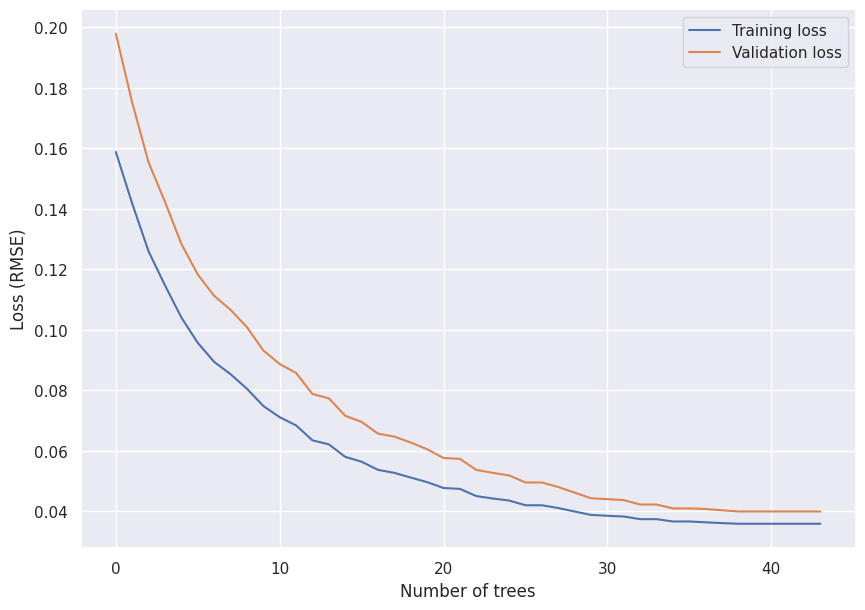

In [108]:
results = GridXGB.best_estimator_.evals_result()

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
# Check if early stopping happened.
if hasattr(GridXGB.best_estimator_, 'best_ntree_limit'):
  plt.axvline(GridXGB.best_estimator_.best_ntree_limit, color="gray",
              label="Optimal tree number")
# Label the axis and show the plot.
plt.xlabel("Number of trees")
plt.ylabel("Loss (RMSE)")
plt.legend()
plt.show()

In [109]:
# Predict over test set
XGB_pred_test = GridXGB.best_estimator_.predict(x_test)

# Calculate the error
XGB_errors = np.abs(XGB_pred_test - y_LGD_test)
XGB_mse = mean_squared_error(XGB_pred_test, y_LGD_test)

# Print it!
print(f'The MSE for the XGB model is {XGB_mse:.3f}')

The MSE for the XGB model is 0.001


XGB achieves, as expected, the lowest error of the models we are testing! This is great as LGD can legally be modelled using these techniques, as they are not used for customer-facing decision-making. Let's plot the error now and see exactly where the gains are.

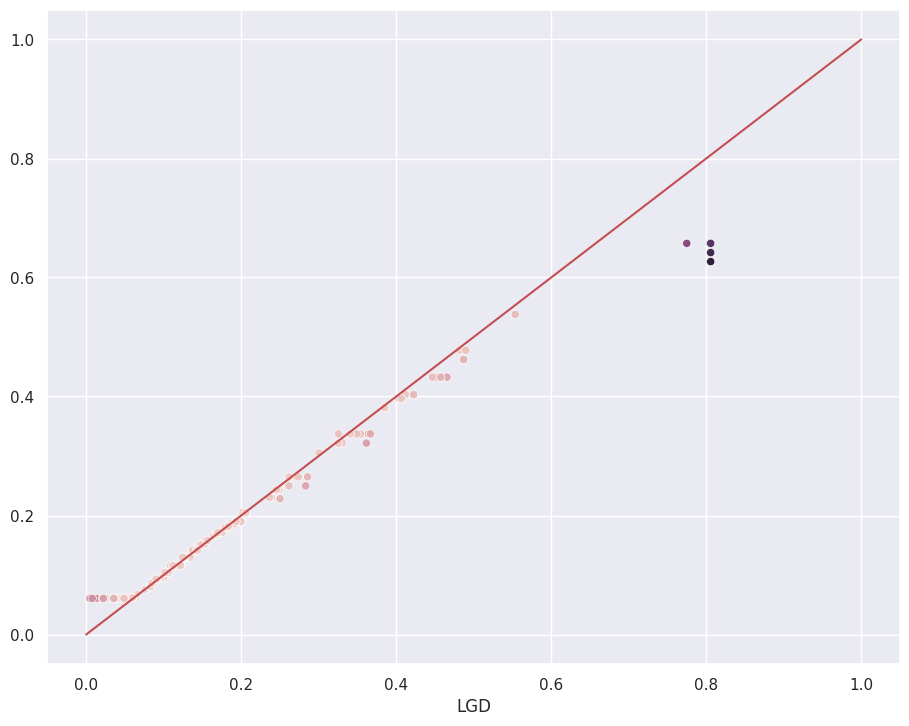

In [110]:
# Print a scatter plot with distributions.
fig, ax = plt.subplots(figsize=(11, 8.5))
sns.scatterplot(x = y_LGD_test,            # The x is the real value
                y = XGB_pred_test,  # The y value is the predictor
                hue = XGB_errors,    # The colour represents the error
                legend = False
                )

# Overlay a diagonal line
X_plot = np.linspace(0, 1, 100)
Y_plot = X_plot

plt.plot(X_plot, Y_plot, color='r')

plt.show()

Much better! The model is able to capture much better the patterns, specially in the middle sector that the other two models failed. That said, the high LGDs are still not very well modelled, which probably means they are structurally different.